**Описание проекта**

Анализ для компании-оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**1. Общая информация**

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [27]:
data_calls = pd.read_csv('calls.csv')
data_calls.info()
data_calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [28]:
data_internet = pd.read_csv('internet.csv')
data_internet.info()
data_internet.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [29]:
data_messages = pd.read_csv('messages.csv')
data_messages.info()
data_messages.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [30]:
data_tariffs = pd.read_csv('tariffs.csv')
data_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [31]:
data_users = pd.read_csv('users.csv')
data_users.info()
data_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Во всех датасетах названия колонок в нижнем "змеином" регистре (За исключением одного - о нем позже). Пропусков нет, за исключением таблицы с пользователями. Там 462 пропуска в колонке churn_date, однако в инструкции к проекту есть указание, что если там пропуск, значит тариф действовал на момент выгрузки данных. В датасете интернет есть столбец Unnamed:0. Не ясно, что это означает, однако по значеним столбца можно увидеть, что они дублируют нумерацию строк в датасете. В предобработке я этот столбец удалю. Его наличие или отсутсвие по всей видимости не будет влиять на исследование, думаю, лучше его удалить, чтоб он не "загрязнял эфир". Так как предстоит считать по месяцам, я приведу к нужному формату значения в колонках дата в датасетах звонки, сообщения и интернет. В датасете звонки я округлю значения в колонке duration до минут, а в интернете - mb_used до гигабайта и все переведу в целочисленный тип данных. В датасете тарифы я переведу мб в гб, округлю вниз и также переведу в целочисленный. Также переименую колонку tariff_name на tariff (как в других датасетах), так как по ней, возможно, буду делать объединение.

**2.1. Предобработка данных**

Перевожу колонки даты в датасетах звонки, сообщения и интернет методом to_datetime(). Добавляю ко всем колонку с номером месяца (month). Проверяю методом head(), что все добавилось.

In [32]:
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y-%m-%d %H:%M')
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d %H:%M')
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d %H:%M')
data_calls['month'] = data_calls['call_date'].dt.month
data_messages['month'] = data_messages['message_date'].dt.month
data_internet['month'] = data_internet['session_date'].dt.month
data_internet.head()


,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,112.95,2018-11-25,1000,11
1,1,1000_1,1052.81,2018-09-07,1000,9
2,2,1000_2,1197.26,2018-06-25,1000,6
3,3,1000_3,550.27,2018-08-22,1000,8
4,4,1000_4,302.56,2018-09-24,1000,9


Перед округлением трафика до гб нахожу сумму трафика по месяцам, так как считаются не отдельные сессии, а трафик за месяц.

In [33]:
mb = data_internet.pivot_table(index=['user_id','month'], values='mb_used', aggfunc='sum')
mb = mb.rename(columns={'mb_used':'mb_month_sum'})
mb

mb_month_sum
user_id month              
1000    5           2253.49
        6          23233.77
        7          14003.64
        8          14055.93
        9          14568.91
...                     ...
1498    10         20579.36
1499    9           1845.75
        10         17788.51
        11         17963.31
        12         13055.58

[3203 rows x 1 columns]

И добавлю подсчеты к таблице с интернетом

In [34]:
data_internet = data_internet.merge(mb, on=['user_id','month'])
data_internet


,Unnamed: 0,id,mb_used,session_date,user_id,month,mb_month_sum
0,0,1000_0,112.95,2018-11-25,1000,11,14756.47
1,18,1000_18,658.10,2018-11-01,1000,11,14756.47
2,19,1000_19,452.73,2018-11-28,1000,11,14756.47
3,26,1000_26,951.38,2018-11-06,1000,11,14756.47
4,29,1000_29,622.43,2018-11-15,1000,11,14756.47
...,...,...,...,...,...,...,...
149391,149249,1499_10,0.00,2018-09-29,1499,9,1845.75
149392,149297,1499_58,6.56,2018-09-28,1499,9,1845.75
149393,149337,1499_98,1138.32,2018-09-29,1499,9,1845.75
149394,149351,1499_112,339.69,2018-09-29,1499,9,1845.75


In [35]:
data_internet['gb_used'] = np.ceil(data_internet['mb_month_sum']/1024).astype('int64')
data_internet

,Unnamed: 0,id,mb_used,session_date,user_id,month,mb_month_sum,gb_used
0,0,1000_0,112.95,2018-11-25,1000,11,14756.47,15
1,18,1000_18,658.10,2018-11-01,1000,11,14756.47,15
2,19,1000_19,452.73,2018-11-28,1000,11,14756.47,15
3,26,1000_26,951.38,2018-11-06,1000,11,14756.47,15
4,29,1000_29,622.43,2018-11-15,1000,11,14756.47,15
...,...,...,...,...,...,...,...,...
149391,149249,1499_10,0.00,2018-09-29,1499,9,1845.75,2
149392,149297,1499_58,6.56,2018-09-28,1499,9,1845.75,2
149393,149337,1499_98,1138.32,2018-09-29,1499,9,1845.75,2
149394,149351,1499_112,339.69,2018-09-29,1499,9,1845.75,2


In [36]:
data_calls['duration'] = np.ceil(data_calls['duration']).astype('int64')
data_calls.info()
data_calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  int64         
 4   month      202607 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 7.7+ MB


,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


Методом np.ceil перевожу значения в большую сторону. По условию, мобильный оператор округляет секунды до минут, а мегабайты - до гигабайт в большую сторону. Проверяю, что округление прошло верно, вызвав head(), а также то, что изменился тип данных, вызвав info()

In [37]:
data_tariffs['mb_per_month_included'] = round(data_tariffs['mb_per_month_included']/1024).astype('int64')
data_tariffs = data_tariffs.rename(columns={'tariff_name':'tariff', 'mb_per_month_included':'gb_included'})
data_tariffs


,messages_included,gb_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15,500,550,200,3,3,smart
1,1000,30,3000,1950,150,1,1,ultra


Методом round округляю значения в колонке мб в месяц, перевожу в гб и в int. Переименовываю колонки название тарифа и мб в месяц

В шаге предобработка данных были проведены следующие операции:
- Округление значений (секунды до минут в большую сторону, мб до гб использованных в большую сторону, мб до гб в тарифе в меньшую сторону)
- Изменение типа данных (в целочисленный, также колонки с датой переведны в формат datetime)
- Переименование колонок (для последующего объединения таблиц)

**2.2. Подготовка данных. Расчеты**

In [38]:
calls_counter_per_month = data_calls.groupby('month')['user_id'].count().to_frame()
calls_counter_per_month

,user_id
month,
1,1476
2,3328
3,6687
4,9272
5,12647
6,14716
7,18298
8,21488
9,24061


In [39]:
minutes_per_month = data_calls.groupby('month')['duration'].sum().to_frame()
minutes_per_month

,duration
month,
1,10784
2,24455
3,48151
4,66310
5,88810
6,105180
7,131746
8,153698
9,173475


Методом groupby нахожу количество звонков по месяцам, а также сумму минут разговора по месяцам. Из таблиц видно, что количество звонков, а также количество минут разговора растет от января к декабрю. Если в январе совершается 1476 звонков, то в декабре их 33987. А по количеству минут: в январе 10748, в июне почти в 10 раз больше (105180), а в декабре больше, чем в два раза от июля (243675). В целом, вероятно, можно сказать, что это нормально, так как в течение года количество пользователей увеличивается

In [40]:
messages_per_month = data_messages.groupby('month')['month'].count().to_frame()
messages_per_month

,month
month,
1,924
2,1924
3,3648
4,5179
5,7298
6,8983
7,11320
8,13088
9,14759


Увеличение активности от января к декабрю наблюдается также и по количетсву отправленных сообщений: в январе - 924, в июле - 11320, в декабре - 20555 (это в 24 раза больше, чем в январе, и почти в 2 раза больше, чем в июле)

In [41]:
internet_per_month = data_internet.groupby('month')['mb_used'].sum().to_frame()
internet_per_month

,mb_used
month,
1,407732.53
2,955251.65
3,1811835.61
4,2433311.62
5,3525862.24
6,4180017.17
7,5029478.75
8,5998157.07
9,6447422.36


Также заметно увеличение трафика от января к декабрю в течение года.

Для расчета помесячной выручки с каждого пользователя буду использовать сводные таблицы и объединение таблиц.

In [42]:
calls_pivot = data_calls.pivot_table(index=['month','user_id'], values='duration', aggfunc='sum')
messages_pivot = data_messages.pivot_table(index=['month','user_id'], values='message_date', aggfunc='count')
internet_pivot = data_internet.pivot_table(index=['month','user_id'], values='gb_used')
general_on_user = calls_pivot.merge(messages_pivot, on=['month','user_id'],how ='outer' )
general_on_user = general_on_user.merge(internet_pivot, on=['month','user_id'],how ='outer')
general_on_user = general_on_user.rename(columns={'duration':'minutes_used','message_date':'messages_sent'})

df_gen = general_on_user.reset_index()
df_gen.head()




,month,user_id,minutes_used,messages_sent,gb_used
0,1,1005,95.0,7.0,3.0
1,1,1032,380.0,38.0,24.0
2,1,1045,9.0,5.0,3.0
3,1,1055,551.0,30.0,17.0
4,1,1071,194.0,16.0,16.0


Делаю свобные таблицы по звонкам, сообщениям и интернету, объединяю их методом merge() и в итоговой таблице переименовываю колонки для большей наглядности. Чтобы в дальнейшем не потерять колонку месяц сохраняю результат с reset_index()

In [43]:
df_gen = df_gen.merge(data_users, on='user_id', how='left')
df_gen.head()

,month,user_id,minutes_used,messages_sent,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1,1005,95.0,7.0,3.0,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
1,1,1032,380.0,38.0,24.0,31,NaN,Ульяновск,Инна,Игнатьева,2018-01-04,smart
2,1,1045,9.0,5.0,3.0,48,NaN,Улан-Удэ,Джемма,Карасева,2018-01-30,smart
3,1,1055,551.0,30.0,17.0,39,NaN,Казань,Луиза,Березина,2018-01-02,smart
4,1,1071,194.0,16.0,16.0,20,2018-08-31,Омск,Гектор,Чумаков,2018-01-09,smart


In [44]:
df_gen = df_gen.merge(data_tariffs, on='tariff')
#df_gen

Присоединяю данные с пользователями и данными тарифа. 

Для расчета помесячной выручки по каждому пользователю найду остатки по пакету (минуты, сообщения, интернет). Сохраню в новых столбцах

In [63]:
df_gen['over_minutes'] = df_gen['minutes_used'] - df_gen['minutes_included']
df_gen['over_messages'] = df_gen['messages_sent'] - df_gen['messages_included']
df_gen['over_gb'] = df_gen['gb_used'] - df_gen['gb_included']
df_gen.head(5)

,month,user_id,minutes_used,messages_sent,gb_used,age,churn_date,city,first_name,last_name,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,over_minutes,over_messages,over_gb,income,total_fee
0,1,1005,95.0,7.0,3.0,67,NaN,Набережные Челны,Афанасий,Горлов,...,500,550,200,3,3,-405.0,-43.0,-12.0,0.0,550.0
1,1,1032,380.0,38.0,24.0,31,NaN,Ульяновск,Инна,Игнатьева,...,500,550,200,3,3,-120.0,-12.0,9.0,1800.0,2350.0
2,1,1045,9.0,5.0,3.0,48,NaN,Улан-Удэ,Джемма,Карасева,...,500,550,200,3,3,-491.0,-45.0,-12.0,0.0,550.0
3,1,1055,551.0,30.0,17.0,39,NaN,Казань,Луиза,Березина,...,500,550,200,3,3,51.0,-20.0,2.0,553.0,1103.0
4,1,1071,194.0,16.0,16.0,20,2018-08-31,Омск,Гектор,Чумаков,...,500,550,200,3,3,-306.0,-34.0,1.0,200.0,750.0


Для расчета стоимости услуг больше пакета напишу функцию одной строки и "пройдусь" ей по значениям остатков минут, сообщений и интернета, сохраню стоимость в новом столбце

In [64]:
def over(row):
    min = row['over_minutes']
    mes = row['over_messages']
    gb = row['over_gb']
    rub_per_min = row['rub_per_minute']
    rub_per_mes = row['rub_per_message']
    rub_per_gb = row['rub_per_gb']
    rub_monthly_fee = row['rub_monthly_fee']
    
    income = 0
    
    if min>0:
        income += min*rub_per_min
    if mes>0:
        income += mes*rub_per_mes
    if gb>0:
        income += gb*rub_per_gb
    return income

df_gen['income'] = df_gen.apply(over, axis=1)
df_gen.head()

,month,user_id,minutes_used,messages_sent,gb_used,age,churn_date,city,first_name,last_name,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,over_minutes,over_messages,over_gb,income,total_fee
0,1,1005,95.0,7.0,3.0,67,NaN,Набережные Челны,Афанасий,Горлов,...,500,550,200,3,3,-405.0,-43.0,-12.0,0.0,550.0
1,1,1032,380.0,38.0,24.0,31,NaN,Ульяновск,Инна,Игнатьева,...,500,550,200,3,3,-120.0,-12.0,9.0,1800.0,2350.0
2,1,1045,9.0,5.0,3.0,48,NaN,Улан-Удэ,Джемма,Карасева,...,500,550,200,3,3,-491.0,-45.0,-12.0,0.0,550.0
3,1,1055,551.0,30.0,17.0,39,NaN,Казань,Луиза,Березина,...,500,550,200,3,3,51.0,-20.0,2.0,553.0,1103.0
4,1,1071,194.0,16.0,16.0,20,2018-08-31,Омск,Гектор,Чумаков,...,500,550,200,3,3,-306.0,-34.0,1.0,200.0,750.0


Сложу все значения платы выше пакета и самого пакета

In [65]:
df_gen['total_fee'] = df_gen['income'] + df_gen['rub_monthly_fee']
df_gen.head()

,month,user_id,minutes_used,messages_sent,gb_used,age,churn_date,city,first_name,last_name,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,over_minutes,over_messages,over_gb,income,total_fee
0,1,1005,95.0,7.0,3.0,67,NaN,Набережные Челны,Афанасий,Горлов,...,500,550,200,3,3,-405.0,-43.0,-12.0,0.0,550.0
1,1,1032,380.0,38.0,24.0,31,NaN,Ульяновск,Инна,Игнатьева,...,500,550,200,3,3,-120.0,-12.0,9.0,1800.0,2350.0
2,1,1045,9.0,5.0,3.0,48,NaN,Улан-Удэ,Джемма,Карасева,...,500,550,200,3,3,-491.0,-45.0,-12.0,0.0,550.0
3,1,1055,551.0,30.0,17.0,39,NaN,Казань,Луиза,Березина,...,500,550,200,3,3,51.0,-20.0,2.0,553.0,1103.0
4,1,1071,194.0,16.0,16.0,20,2018-08-31,Омск,Гектор,Чумаков,...,500,550,200,3,3,-306.0,-34.0,1.0,200.0,750.0


Таким образом, в колонке total_fee сохранена помесячная оплата по каждому пользователю, включая сам пакет и услуги, которые превысили пакет для тех, кто превысил

В шаге подсчетов были расчитаны:

а) По месяцам
   - количество минут разговора
   - оправленных сообщений
   - использованного трафика в гб 
   
б) Помесячная выручка по каждому пользователю 

**3. Анализ данных**

Для ответа на вопрос сколько требуется минут разговора, сообщений и интернета в месяц пользвателям каждого тарифа построю сводную таблицу с подсчетом среднего, дисперсии и стандартного отклонения

*Среднее, дисперсия и стандартное отклонение*

In [66]:
df_gen.pivot_table(index='tariff', values=['minutes_used','messages_sent','gb_used'], aggfunc= [np.mean, np.var, np.std]).round(2)


mean                                var                             \
       gb_used messages_sent minutes_used gb_used messages_sent minutes_used   
tariff                                                                         
smart    16.34         38.72       419.06   32.92        717.59     35844.19   
ultra    19.69         61.16       545.45   94.15       2109.66     94203.42   

           std                             
       gb_used messages_sent minutes_used  
tariff                                     
smart     5.74         26.79       189.33  
ultra     9.70         45.93       306.93

*Гистограмма минут разговора для двух тарифов*

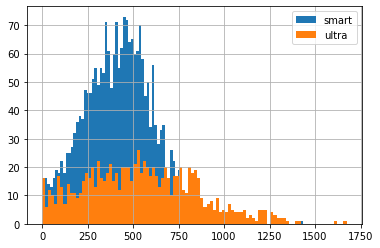

In [67]:
smart = df_gen.query('tariff == "smart"')
ultra = df_gen.query('tariff == "ultra"')
smart['minutes_used'].hist(bins=100, label='smart')
ultra['minutes_used'].hist(bins=100, label='ultra')
plt.legend()
plt.show()


Значения в таблице и графики показывают, что по минутам разговора в среднем пользователи обоих тарифов "укладываются" в пакет, то есть не расходуют больше того, что включено в тариф. Пользователи тарифа ультра расходуют больше, чем пользователи смарта. И если при включенных 500 минутах в тарифе смарт, среднее близко к а границе (500 минут), а пользователи ультра далеки от своей границы (3000 минут), можно заключить, что пользователи смарта чаще выходят "из пакета" по минутам и тратят дополнительно на поминутной тарификации. Значения распределны нормально, есть небольшая ассиметрия

*Гистограмма Отправленные сообщения*

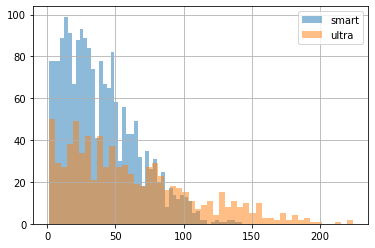

In [68]:
smart['messages_sent'].hist(bins=50,alpha=0.5, label='smart')
ultra['messages_sent'].hist(bins=50, alpha=0.5, label='ultra')
plt.legend()
plt.show()

В среднем пользователи ультра отправляют сообщений больше, чем пользователи смарта (примерно в 1,2-2 раза в зависимости от месяца). При этом пакетно их лимиты отличаются в 20 раз. Подробнее посмотрю на значения этих колонок методом describe

In [70]:
smart['messages_sent'].describe()

count    1922.000000
mean       38.716441
std        26.787949
min         1.000000
25%        17.000000
50%        34.000000
75%        55.000000
max       143.000000
Name: messages_sent, dtype: float64

In [71]:
ultra['messages_sent'].describe()

count    795.000000
mean      61.161006
std       45.931026
min        1.000000
25%       24.000000
50%       51.000000
75%       87.500000
max      224.000000
Name: messages_sent, dtype: float64

Пользователи ультра за исследуемый период вообще не выходят за пределы пакета по сообщениям - максимальное значение 224 (против 1000 сообщений в пакете). А пользователи смарта очевидно выходят: среднее - 38, медиана - 34, 75%квартиль - 55. Максимальное значение - 143 (против 50 сообщений в пакете). Обе гистограммы также имеют небольшую положительную скошенность - больше значений справа от оси

*Расход трафика*

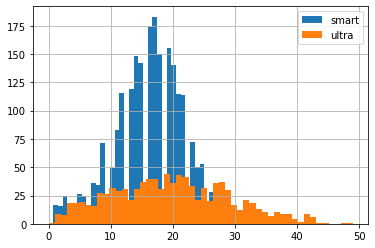

In [72]:
smart['gb_used'].hist(bins=50, label='smart')
ultra['gb_used'].hist(bins=50, label='ultra')
plt.legend()
plt.show()

Добавлю к описанию "сухие цифры"

In [73]:
smart['gb_used'].describe()

count    2228.000000
mean       16.336176
std         5.737923
min         0.000000
25%        13.000000
50%        17.000000
75%        20.000000
max        38.000000
Name: gb_used, dtype: float64

In [74]:
ultra['gb_used'].describe()

count    975.000000
mean      19.694359
std        9.702924
min        0.000000
25%       12.000000
50%       19.000000
75%       27.000000
max       49.000000
Name: gb_used, dtype: float64

По расходованию трафика картина следующая: Пользователи смарта в среднем превышают лимит пакета примерно на 1-2гб. Максимальное значение в этой группе - 38(это превышение на 23). Пользватели ультра в среднем также "укладываются" в свой лимит по гб (примерно 19-20 гб в месяц против 30 в тарифе)

Анализ данных показал некоторые различия в поведении пользователей. По использованию минут разговора и отправке сообщений, пользователи ультра почти никогда не выходят за лимит, тогда как смарт-пользователи выходят и по минутам, и по сообщениям. Можно сказать, что смарт-пользователи по этим услугам больше тратят на дополнительных минутах и сообщениях. По расходованию трафика в среднем ультра не выходят за лимит (около 20 гб против 30 в тарифе), а вот пользователи смарт используют примерно 16 гб против 15 в тарифе. Таким образом, они в среднем чаще превышают лимит своего тарифа. Однако не стоит забывать, что тариф ультра дороже смарта. Нужно понять по удельной выручке с клиентов, кто же все-таки приносит больше дохода компании.

**4. Проверка гипотез**

Нужно проверить две гипотезы:
- средняя выручка пользователей ультра и смарт различаются
- средняя выручка пользователей из Москвы отличается от выручки пользователей других регионов

*Формулирование гипотез*

1) - Нулевая гипотеза (Н0) - средняя выручка пользователей ультра и смарт равны
   - Альтернативная гипотеза (Н1) = средняя выручка пользователей ультра и смарт не равны
   
2) - Нулевая гипотеза (Н0) - средняя выручка пользователей из Москвы равна средней выручке пользователей других регионов
   - Альтернативная гипотеза (Н1) - средняя выручка пользователей из Москвы не равна средней выручке пользователей других регионов

In [75]:
sample_smart = smart['total_fee']
sample_ultra = ultra['total_fee']

Необходимые для теста массивы сохраняю в переменные sample

Так как предстоит сравнить две средние совокупности, взятые по выборкам, я буду использовать тест ttest_ind

In [76]:
alpha = .05
results = st.ttest_ind(sample_smart,sample_ultra)
results.pvalue

display('p-значение:',results.pvalue)

if results.pvalue < alpha:
    display('Отвергаем нулевую гипотезу')
else:
    display('Не отвергаем нулевую гипотезу')

display ('Выручка по смарт Среднее', sample_smart.mean())
display ('Выручка по ультра Среднее', sample_ultra.mean())

'p-значение:'

1.4229814360764067e-160

'Отвергаем нулевую гипотезу'

'Выручка по смарт Среднее'

1289.9735307312696

'Выручка по ультра Среднее'

2070.1522842639592

Результат - средняя выручка пользователей смарт и ультра не равны

Для проверки второй части также сохраняю массивы в переменных

In [77]:
sample_moscow = df_gen.query('city == "Москва"')['total_fee']
sample_other = df_gen.query('city != "Москва"')['total_fee']

In [78]:
alpha = .05
results = st.ttest_ind(sample_moscow,sample_other) 
results.pvalue

display('p-значение:', results.pvalue)
if results.pvalue < alpha:
    display('Отвергаем нулевую гипотезу')
else:
    display('Не отвергаем нулевую гипотезу')
    
display ('Выручка по Москве Среднее', sample_moscow.mean())
display ('Выручка по регионам Среднее', sample_other.mean())

'p-значение:'

0.5440152911670224

'Не отвергаем нулевую гипотезу'

'Выручка по Москве Среднее'

1546.7135842880523

'Выручка по регионам Среднее'

1524.9362274298885

Проверка гипотезы о равенстве средней выручки Москвы и других регионов дала результат "не равны"

Чтобы ответить на вопрос, какой тариф приносит больше денег компании, я дополнительно посмотрю на сведения об оплате

In [79]:
sample_smart.describe()

count    2229.000000
mean     1289.973531
std       818.404367
min       550.000000
25%       550.000000
50%      1023.000000
75%      1750.000000
max      6770.000000
Name: total_fee, dtype: float64

In [80]:
sample_ultra.describe()

count     985.000000
mean     2070.152284
std       376.187114
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: total_fee, dtype: float64

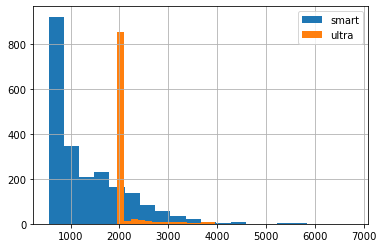

In [81]:
sample_smart.hist(bins=20, label='smart')
sample_ultra.hist(bins=20, label='ultra')
plt.legend()
plt.show()

В среднем всего больше тратят ультра-пользователи(2048р) и большая часть их трат приходится на оплату пакета. У пользователей смарт на оплату пакета уходит около 60%, остальное - дополнительные минуты, сообщения, гб. Гистограмма наглядно показывает распределение для двух групп пользователей. И несмотря на то, что пользователи ультра в целом тратят больше, я назову более перспективным тарифом смарт, так как количество пользователей смарт намного превышает ультра и общим итого они могут принести больше дохода оператору сотовой связи.

**Общий вывод**

Несмотря на то, что тариф смарт стоит дешевле почти в 4 раза, чем ультра, пользователи смарта по всем услугам (звонки, сообщения, интернет) превышают лимит и больше платят за дополнительные минуты и сообщения(3р против 1р у ультра) и за интернет (200 против 150). Также нужно сказать, что количество пользователей смарт больше. Исходя из вышесказанного, я бы назвала смарт более перспективным тарифом для телеком-компании. Однако не совсем справедливо будет основываться на количестве пользователей, это число может быть изменчивым. По среднему пользователи ультра приносят больше выручки.